In [1]:
import torch
import pickle

import matplotlib.pyplot as plt


with open('train_loss.pkl', 'rb') as file:
    loaded_data = pickle.load(file)


loaded_data.shape

torch.Size([12, 4])

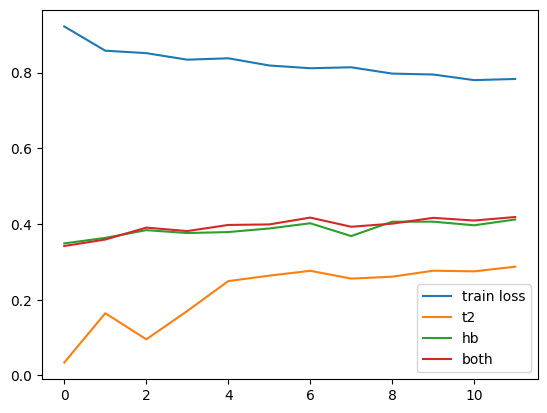

In [2]:
plt.plot(loaded_data[:200, 0], label='train loss')
plt.plot(loaded_data[:200, 1], label='t2')
plt.plot(loaded_data[:200, 2], label='hb')
plt.plot(loaded_data[:200, 3], label='both')
plt.legend()

In [3]:
from DataLoading import *
from monai.networks.nets.swin_unetr import SwinUNETR
from monai.losses import DiceLoss, FocalLoss, DiceFocalLoss
from Training import *
import pickle
from monai.transforms import *
import matplotlib.pyplot as plt
# spilt the dataset
seg_list_picai, agent_train_picai, agent_test_picai = spilt_data('picai_miccai_data_human', 70, 120, 30)
seg_list_pormise, agent_train_pormise, agent_test_pormise = spilt_data('promise_miccai-new', 151, 220, 60)

seg_list = seg_list_picai + seg_list_pormise
agent_train = agent_train_picai + agent_train_pormise
agent_test = agent_test_picai + agent_test_pormise

device = 'cuda:1'

model = SwinUNETR(
    (128, 128, 64),
    2,
    1,
    downsample='mergingv2',
    use_v2=True
)


test_loader = get_loader(agent_test, ReadH5d(), 1, True, True)
model.load_state_dict(torch.load('T2HbSeg.ptm', map_location=device))
model.to(device)

batch = next(iter(test_loader))

/home/xiangcen/miniconda3/envs/dl/lib/python3.12/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)
/tmp/ipykernel_2963/2242732853.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed 

In [4]:



with torch.no_grad():
    # Call the selected condition function
    img_t2, _ = get_t2_image(batch, device)
    img_hb, _ = get_hb_image(batch, device)
    img_both, gt = get_both(batch, device)




    # forward pass of selected data
    output_t2 = model(img_t2).cpu().detach()
    output_hb = model(img_hb).cpu().detach()
    output_both = model(img_both).cpu().detach()
    
    t2_prediction = PostInference(output_t2)
    hb_prediction = PostInference(output_hb)
    both_prediction = PostInference(output_both)
    gt = gt.cpu().detach()





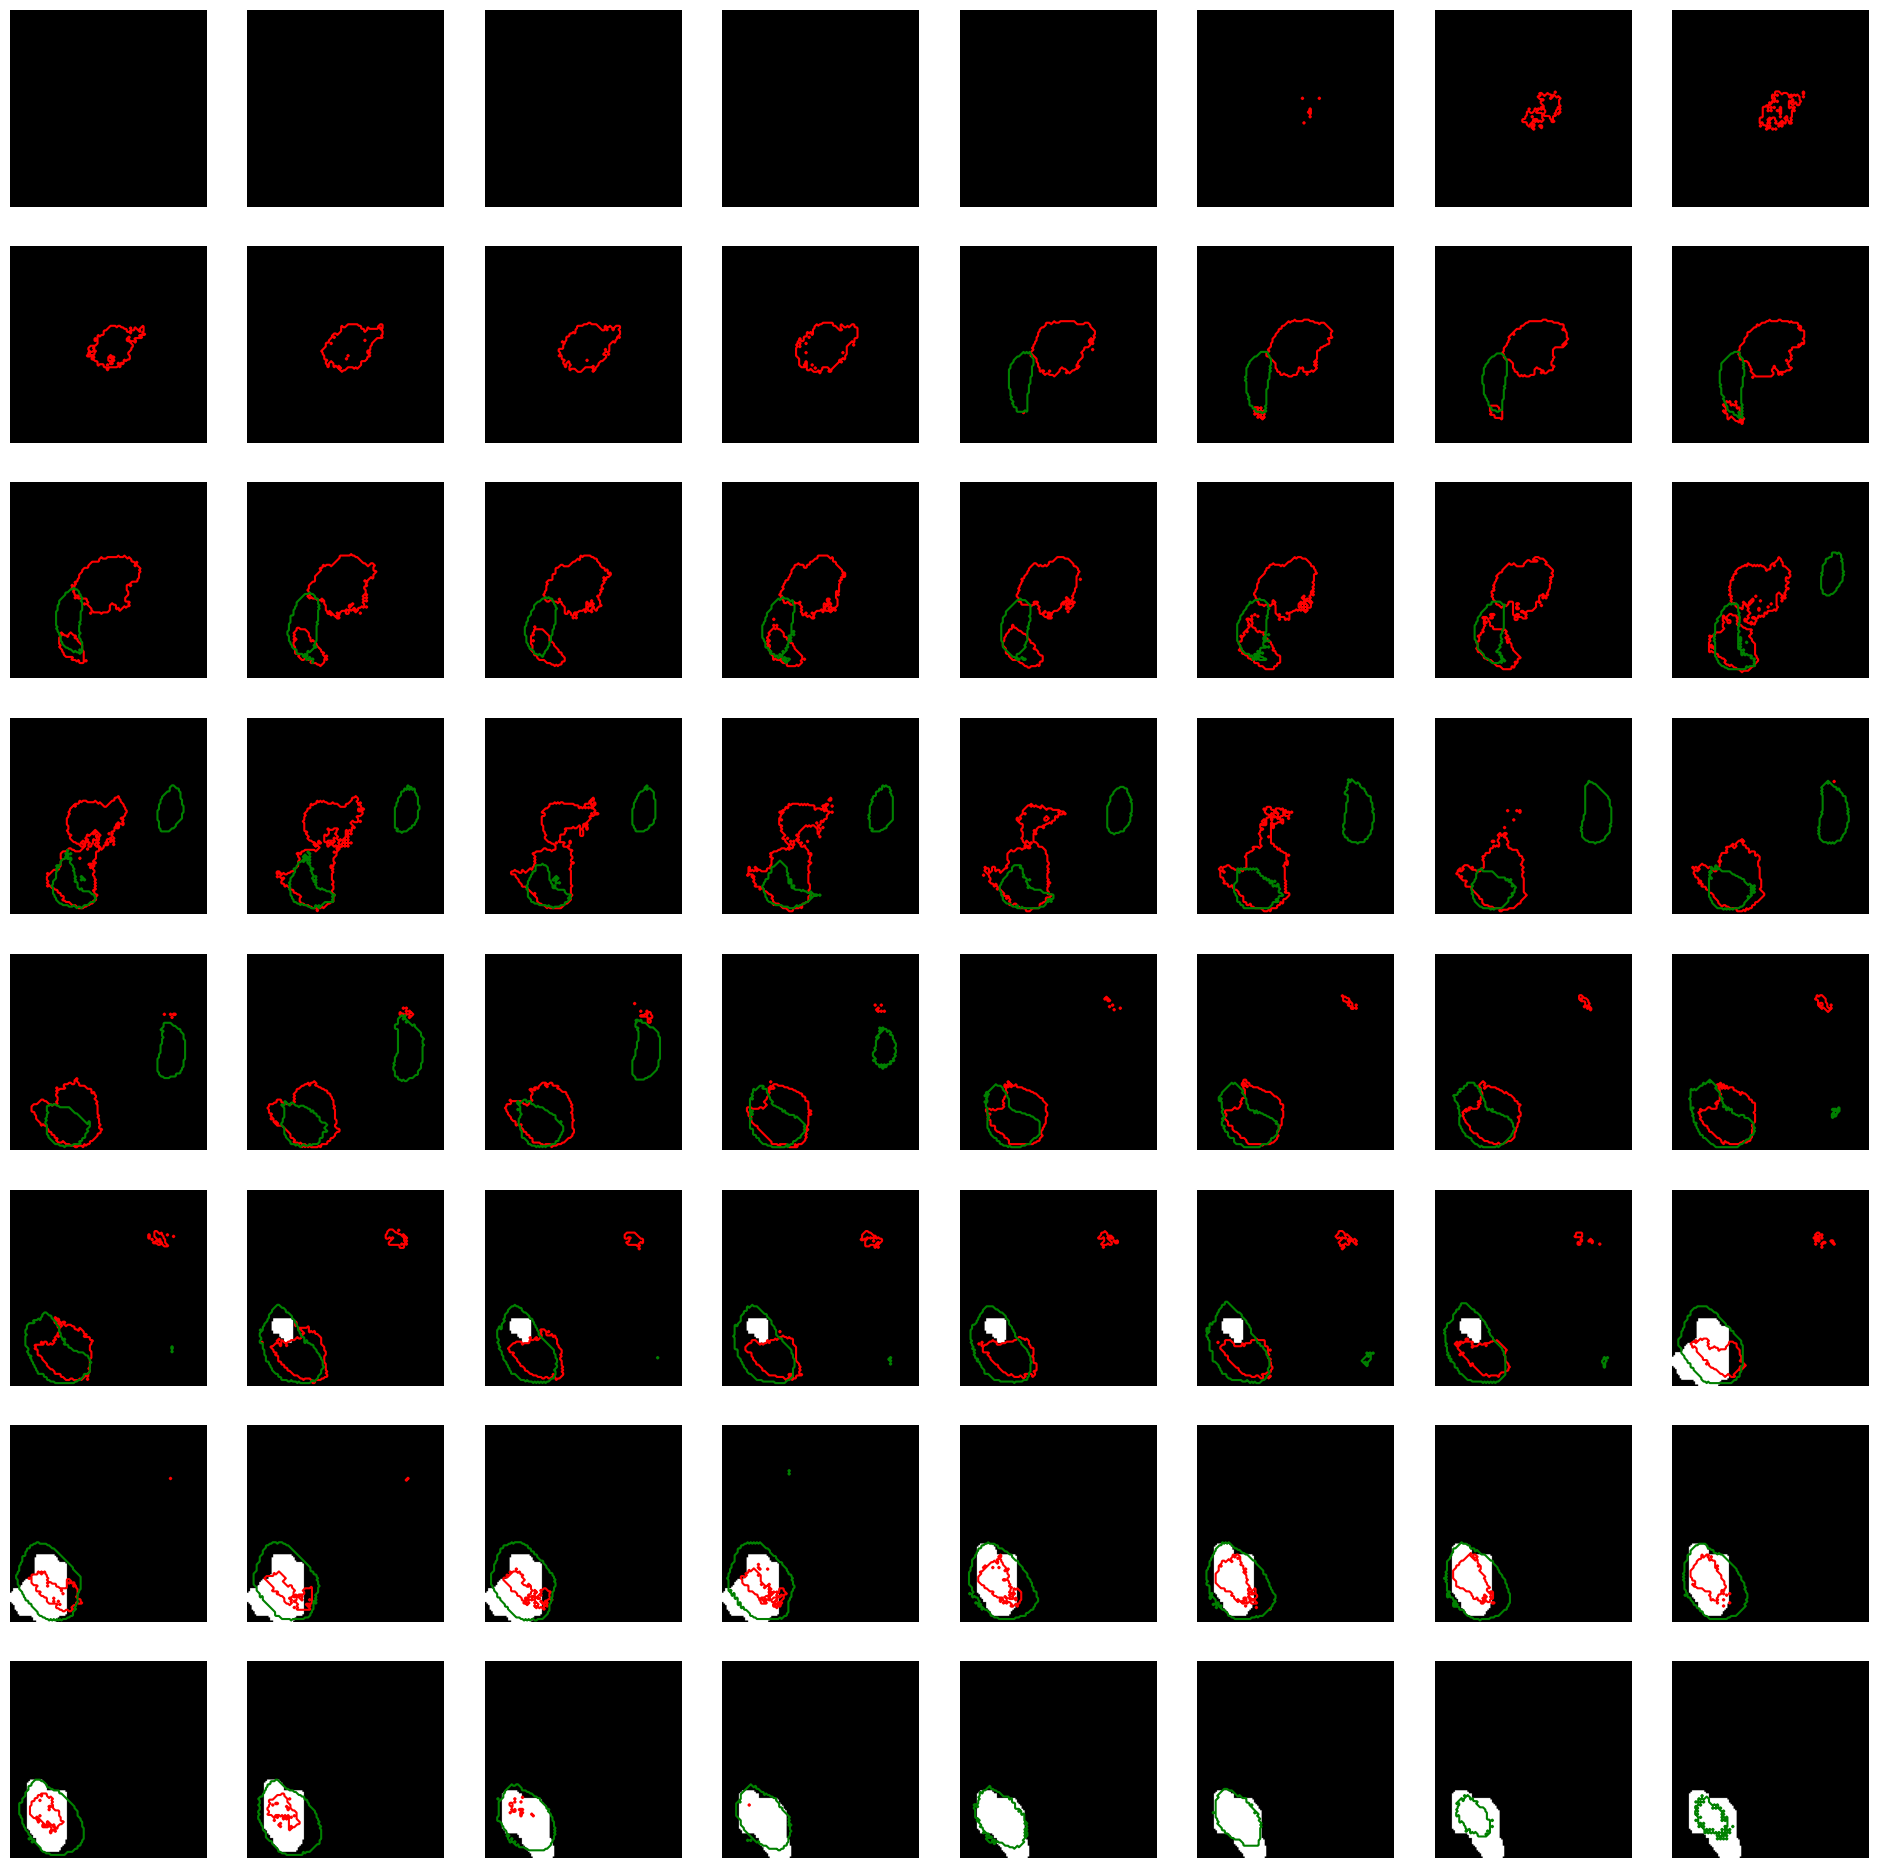

In [5]:
n_rows, n_cols = 8, 8

# Create a figure with specified grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 24))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i in range(64):
    axes[i].imshow(gt[0, 0, :, :, i], cmap='gray')  # Adjust `cmap` if your images are RGB
    axes[i].contour(t2_prediction[0, 0, :, :, i], levels=[0.5], colors='red')
    axes[i].contour(hb_prediction[0, 0, :, :, i], levels=[0.5], colors='green')
    axes[i].axis('off')  # Turn off axis for each subplot